In [1]:
# this is to import the xml.etree.ElementTree to read the XMl file
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline

Part-1:
This part is for the importing of the data set and making a data frame

In [2]:
# the following will assigning the variable tree the value of parsed data of brazil58.xml
tree = ET.parse('brazil58.xml')
# the following will assigning the root of the data in the tree variable (brazil58) to the root variable
root = tree.getroot()

In [3]:
# this will create a dictionary to store edge costs for vertices with alphabetical names
vertex_costs = {}

# the follwoing will itterate through verteces 
# this will ensure that the vertex and edge start with 'A' as the first vertex name
current_vertex = ord('A')  
current_edge = ord('A')

for vertex in root.findall(".//vertex"):
    vertex_name = chr(current_vertex)  # Convert the current_vertex value to a letter (e.g., 'A', 'B', 'C', ...)
    edge_costs = [float(edge.get("cost")) for edge in vertex.findall("edge")]

#     this will name the edges as 'A', 'B',... and so on, starting from 'A' but skipping the current_vertex
    edge_names = [chr(current_edge + i) for i in range(len(edge_costs) + 1) if current_edge + i != ord(vertex_name)]

#     now we will create a dictionary to store edge names and costs for the current vertex
    edge_info = dict(zip(edge_names, edge_costs))

    vertex_costs[vertex_name] = edge_info
    current_vertex += 1 
    current_edge = ord('A')

Creating a dataframe

In [4]:
# the following code will create a data frame so as to make the computation easey 
data_frame_of_cities = []

for city1, city2_dict in vertex_costs.items():
        for city2, cost in city2_dict.items():
            entry = {
            'City 1': city1,
            'City 2': city2,
            'Cost': cost
        }
            data_frame_of_cities.append(entry)
        
data_frame_of_cities = pd.DataFrame(data_frame_of_cities)
data_frame_of_cities

,City 1,City 2,Cost
0,A,B,2635.0
1,A,C,2713.0
2,A,D,2437.0
3,A,E,1600.0
4,A,F,2845.0
...,...,...,...
3301,z,u,1446.0
3302,z,v,1345.0
3303,z,w,1408.0
3304,z,x,2986.0


In [7]:
# this will create a list of dataframe created above for reducing time complexity
data_list_of_cities = data_frame_of_cities.to_dict(orient='records')

Part-2:
This part is the for the population generations, completing the loop and calculating the cost

Now we will generate a population of size determinde by user input

In [9]:
# the following function will generate n sample populations of all the cities in the column City 1
def random_population_generator(data_frame, n):
    cities = sorted(data_frame['City 1'].unique())  
    combinations = set()  

    while len(combinations) < n:
        # this will generate a random permutation of the cities
        random_combination = ''.join(random.sample(cities, len(cities)))

#         this will add the combination to the set (if it is not present already present)
        combinations.add(random_combination)
    return list(combinations)

In [10]:
# this code will just complete the entire loop of string
def complete_loop_strings(list_of_strings):
    completed_strings = [string + string[0] for string in list_of_strings]
    return completed_strings

In [11]:
#  the following function will convert the list of strings to a list of tuples
def convert_travel_list_to_tuples(string_list):
    result = []
    for city_travel in string_list:
        travel_tuples = []
        for i in range(len(city_travel) - 1):
            travel_tuples.append((city_travel[i], city_travel[i + 1]))
        result.append(travel_tuples)
    return result

In [12]:
def total_cost_list(data_list, travel_legs):
#     this will create a dictionary to map (city_1, city_2) pairs to their costs
    cost_dict = {(row['City 1'], row['City 2']): row['Cost'] for row in data_list}

    total_costs = []  
    for legs in travel_legs:
        cost_of_complete_travel = sum(cost_dict.get((city_1, city_2), 0) for city_1, city_2 in legs)
        total_costs.append(cost_of_complete_travel)  
    return total_costs

The follwoing code will crate a data frame of the random populations (paths) generated and the cost calculated of each path

the following code is just for displaying the complete loop of the cities in the dataframe to show that the complete path is calculated and the end point is the starting point, that is to say that the city we start with is the city we end at

In [13]:
# this function will take in lists and will generate the dataframe
def dataframe_generator(path,cost):
    data = {
        'Path':path,
        'Cost':cost
    }
    df = pd.DataFrame(data)
    return df

Part-3:
This part is regarding the experimentation with the population using operations such as tornament, mutation and crossover

The following code will be regarding the tournament selection. It is here where we will select the tournament size and the tournament winners

In [14]:
# this function will select randomly from the population created above by random population generator
def tournament_selection(population , number_of_selected_candidates):
    selected_paths = random.sample(population,number_of_selected_candidates)
    return selected_paths

In [15]:
# the following code will complete the loop of the cities adding the path from the last city to the first city
def add_last_city_to_first(tuples_list):
    modified_list = []
    for sublist in tuples_list:
#         this will add the tuple with the last and first element
        modified_sublist = sublist + [(sublist[-1][1], sublist[0][0])]
        modified_list.append(modified_sublist)
    return modified_list

The following code will calculate which of the contenders in tournament 1 and 2 have the highest fitness that is to say that they have the least cost

In [16]:
'''this function code is for the tournament selection, it will conduct the tournament to calculate which is the fittest
option out of the generated tournament_selection'''
def tournament(travel_legs, total_costs):
#     this will nitialize min_cost to positive infinity
    min_cost = float('inf')  
    best_legs = None

    for i, cost in enumerate(total_costs):
        if cost < min_cost:
            min_cost = cost
            best_legs = travel_legs[i]
    return best_legs, min_cost

The following code is to implement the single point cross-over or the uniform crossover, this code will treat the fittes_contender_tournament_1 and 2 as the parent 1 and 2 respectively and select a random single point corssover or uniform corssover and produce two children. Incase a city is repeated in the child it will remove that and replace it with a city thats not available in th child

In [19]:
def random_single_point_crossover(parent1, parent2):
#     the following code will ensure that the length of both parents is the same
    if len(parent1) != len(parent2):
        raise ValueError("Parents must have the same length")

#     the following lines of code will randomly select a crossover point from point 1 till the second last point
    crossover_point = random.randint(1, len(parent1) - 1)
#     print('Crossover point is', crossover_point)
#     the following lines will corssover the parent 1 and the parent 2 to make the child 1 and 2 depending on the crossover point
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    return child1, child2

In [20]:
# the following code will perform a uniform crossover if the user decides
def uniform_crossover(parent1, parent2):
#     the following code will ensure that the length of both parents is the same
    if len(parent1) != len(parent2):
        raise ValueError("Parents must have the same length")

#      the following will generate a binary mask for the crossover
    crossover_binary_mask = [random.choice([0, 1]) for _ in range(len(parent1))]

#     this will initilize the child strings
    child1 = ""
    child2 = ""
#     the following will apply thebinary mask
    for i in range(len(parent1)):
        if crossover_binary_mask[i] == 1:
            child1 += parent2[i]
            child2 += parent1[i]
        else:
            child1 += parent1[i]
            child2 += parent2[i]
    return child1, child2

the following function check and fix will ensure that each city(alphabet) appears exactly once in a string

In [21]:
'''the following code will fix the children so that each city(letter) appears only once, if a letter is appearing 
again it will replace and the length of the child will not be changed'''
def check_and_fix(child, parent):
#     this creates tow sets of unique characteracters of parent and child
    parent_set = set(parent)
    child_set = set(child)

#     this will find the  characteracters in child that are repeated
    repeated_characters_child = [character for character in child if child.count(character) > 1]

#     the fillowing code will replace repeated characteracters in child with missing characteracters from parent
    for character in repeated_characters_child:
        missing_characters = parent_set - child_set
        if missing_characters:
            replacement = missing_characters.pop()
            child = child.replace(character, replacement, 1)
            child_set.add(replacement)
    return child

The following code will run the Mutation funciton on the children produced in the above code and it will give new solution after the complettion of the mutation function.

In [19]:
# the follwoing code will apply mutation on the children produced after swap mutation
def mutation(child, n):
    if n < 1:
        return child
    
    child_list = list(child)

    for _ in range(n):
#         this will select two random indices in the child
        indices = random.sample(range(len(child_list)), 2)

#         this swaps the characters at the selected indices
        child_list[indices[0]], child_list[indices[1]] = child_list[indices[1]], child_list[indices[0]]

    mutated_child = ''.join(child_list)
    return mutated_child

the following code will compare the mutants data frame with the original data frame and make replacements on the basis of fitness of the elements

In [20]:
# the following funcion will look at the original dataframe and compare the mutant
def update_df_with_mutants(df, mutants_dataframe):
    for idx, row in mutants_dataframe.iterrows():
        path = row['Path']
        cost = row['Cost']
#         find the index where the cost is lower
        lower_cost_indices = df[df['Cost'] > cost].index
        
        if not lower_cost_indices.empty:
            # replace the row with the highest cost
            highest_cost_index = df['Cost'].idxmax()
#             print(highest_cost_index)
            df.at[highest_cost_index, 'Path'] = path
            df.at[highest_cost_index, 'Cost'] = cost
    return df

In order to reduce the time complexity the following function was made which takes as input the two lists of the original population and the mutatns and outputs the list containing the least costs. it basically does the same thing as above but in reduced timings

In [21]:
def update_list_with_mutants(list1, list2):
    for mutant in list2:
        path = mutant['Path']
        cost = mutant['Cost']

#         this will find the indices in list 1 where the cost is higher
        higher_cost_indices = [i for i, item in enumerate(list1) if item['Cost'] > cost]

        if higher_cost_indices:
#             this will fiind the index of the item with the highest cost in list1
            highest_cost_index = max(higher_cost_indices, key=lambda i: list1[i]['Cost'])

#             the fillowing will replace the item with the highest cost in list1 with the mutant
            list1[highest_cost_index]['Path'] = path
            list1[highest_cost_index]['Cost'] = cost

    return list1

In [23]:
def calculate_cost_statistics(paths_dataframe_to_list): 
#   this will hodl the values as specified 
    max_cost = float('-inf')
    min_cost = float('inf')
    total_cost = 0
#   this will itterate over the values in the path_dataframe_to_list
    for path in paths_dataframe_to_list:
        cost = path['Cost']
        total_cost += cost
#       this will add the max cost
        if cost > max_cost:
            max_cost = cost
#       this will add the min cost
        if cost < min_cost:
            min_cost = cost
#   this will calculate the mean cost
    mean_cost = total_cost / len(paths_dataframe_to_list)
    return max_cost, min_cost, mean_cost

Part-4:
The following code will be regarding the running of the experiment and all the relevant outputs for the data
it is here the experiment parameters will be inputted by the user and the output and the plot will be made

In [131]:
# the following code will ask for the sieze of the random population
sample_population_size = int(input('Please enter the size of the population '))
random_population = random_population_generator(data_frame_of_cities , sample_population_size)
random_population_complete_loop_string = complete_loop_strings(random_population)
complete_loop_travel_path = convert_travel_list_to_tuples(random_population_complete_loop_string)
complete_loop_travel_path_cost = total_cost_list(data_list_of_cities , complete_loop_travel_path)
paths_dataframe = dataframe_generator(random_population_complete_loop_string , complete_loop_travel_path_cost)

#the following will convert the data frame to list for reducing time complexity
paths_dataframe_to_list = paths_dataframe.to_dict(orient='records')

# this will ask for the tournament size
number_of_contenders_for_tournament = int(input('Please enter the number of contenders for the tournament '))

# the following code will ask the user if they want to perform crossover or not
crossover_check = input('Do you want to perform crossover or not? (Y/N) ')
if (crossover_check == "Y"):
    # this will ask the user if he wants a single point crossover or a uniform corssover
    type_of_crossover = input('Which type of crossover should be performed, enter 1 for single and 2 for uniform crossover')
    

# this asks the user if he wants to perform mutation or not
mutation_check = input('Do you want to perform mutation or not? (Y/N) ')

if (mutation_check == 'Y'):
    # this will ask for the type of mutation
    type_of_mutaiton = input('please enter the type of mutaiton, press 1 for single/multiple point mutation and 2 for full mutation ')
    if(type_of_mutaiton == '1'): 
        # this will ask for the number of points to be mutated
        no_of_genes_to_mutate = int(input('Please enter the number of mutation level, 1 means single point mutation '))
    elif(type_of_mutaiton == '2'):
        #this will mutate all the solution
        no_of_genes_to_mutate = int(len(random_population[0])/2)
elif (mutation_check == 'N'):
    no_of_genes_to_mutate = 0
# the number of itterations the code should run for
number_of_itterations = int(input('Please enter the number of itterations the code should run for '))

Please enter the size of the population 100
Please enter the number of contenders for the tournament 20
Do you want to perform crossover or not? (Y/N) Y
Which type of crossover should be performed, enter 1 for single and 2 for uniform crossover1
Do you want to perform mutation or not? (Y/N) Y
please enter     the type of mutaiton, press 1 for single/multiple point mutation and 2 for full mutation 1
Please enter the number of mutation level, 1 means single point mutation 1
Please enter the number of itterations the code should run for 10000


In [132]:
# this will create an array for plotting
itteration = []
for i in range(number_of_itterations):
    itteration.append(i)

In [133]:
max_cost_path = max(paths_dataframe_to_list, key=lambda x: x['Cost'])
max_cost = max_cost_path['Cost']
# this will caalculate the path with the minimum cost
min_cost_path = min(paths_dataframe_to_list, key=lambda x: x['Cost'])

# this will calculate the mean cost
total_cost = sum(path['Cost'] for path in paths_dataframe_to_list)
mean_cost = total_cost / len(paths_dataframe_to_list)

print('Max cost before itteration is :',max_cost_path)
print('Mean cost before itteration is :',mean_cost)
print('Min cost before itteration is :',min_cost_path)

Max cost before itteration is : {'Path': 'uJqWxQPMUFR[CaewSTcXGZEsyOjzDvobhHmAVgY\\L_I^t`nirBdlpNfKk]u', 'Cost': 145177.0}
Mean cost before itteration is : 125481.31
Min cost before itteration is : {'Path': 'x_KF\\Us[PtnZfiNLaVczuRpQdMwqBmH]kbXI^CrDeAWGjEghYyJOoT`vlSx', 'Cost': 107050.0}


In [134]:
%%time

max_cost_list = []
mean_cost_list = []
min_cost_list = []

for i in range(number_of_itterations):
    '''the followind code will ask for the user to specify the size of each tournament and then will output the 
    tournament_contenders for 1 and 2'''
    tournament_contenders_1 = tournament_selection(random_population , number_of_contenders_for_tournament)
    tournament_contenders_2 = tournament_selection(random_population , number_of_contenders_for_tournament)
    
    '''The following code will convert the tournament contenders from list of strings to list of tuples using the 
    function convert_travel_list_to_tuples() stated above.'''
    tournament_contenders_1_list = convert_travel_list_to_tuples(tournament_contenders_1)
    tournament_contenders_2_list = convert_travel_list_to_tuples(tournament_contenders_2)
    
    '''the following will ensure that the city we start from is the same as the city we end at'''
    tournament_contenders_1_list_complete_loop = add_last_city_to_first(tournament_contenders_1_list)
    tournament_contenders_2_list_complete_loop = add_last_city_to_first(tournament_contenders_2_list)
   
    # The following code is to calculate the cost of the tournament contenders using the function total_cost() as stated above
    cost_tournament_1_contenders = total_cost_list(data_list_of_cities , tournament_contenders_1_list_complete_loop)
    cost_tournament_2_contenders = total_cost_list(data_list_of_cities , tournament_contenders_2_list_complete_loop)
    
    '''this code will take as input the name of the contenders and their cost, this merely checks the cost and outputs the one
    with the least cost'''
    fittest_contender_tournament_1 = tournament(tournament_contenders_1 , cost_tournament_1_contenders)
    fittest_contender_tournament_2 = tournament(tournament_contenders_2 , cost_tournament_2_contenders)
    
    # this will assign winners of tournament as parents 1a and 2b
    parent_1_a = fittest_contender_tournament_1[0]
    parent_2_b = fittest_contender_tournament_2[0]

    # this will check if the user wants to perfrom crossover or not
    if (crossover_check == 'Y'): #if the user wants to perform crossover
        
        # if the user wants single point crossover
        if(type_of_crossover == '1'):
            
            # the following code will use the function above to form the child c and d from the parents a and b using the crossover
            child_1_c , child_2_d = random_single_point_crossover(parent_1_a , parent_2_b)

            # the following will ensure using the function check and fix() stated above that each city appears exactly once
            child_1_c = check_and_fix(child_1_c , parent_1_a)
            child_2_d = check_and_fix(child_2_d , parent_2_b)
        
        #if the user wants uniform crossover
        elif(type_of_crossover == '2'):
            
            # the following code will use the function above to form the child c and d from the parents a and b using the crossover
            child_1_c , child_2_d = uniform_crossover(parent_1_a , parent_2_b)
#             print(child_1_c , child_2_d)
            
            # the following will ensure using the function check and fix() stated above that each city appears exactly once
            for j in range(len(child_1_c)//2):
                child_1_c = check_and_fix(child_1_c , parent_1_a)
                child_2_d = check_and_fix(child_2_d , parent_2_b)
         #if the user dosen't want to perfrom crossover
    elif (crossover_check == 'N'):
        #assign the child the values of the tournament winner
        child_1_c = parent_1_a
        child_2_d = parent_2_b

        # using the mutation() function stated above the follwing will apply mutation on the children
    mutant_1_e = mutation(child_1_c , no_of_genes_to_mutate)
    mutant_2_f = mutation(child_2_d , no_of_genes_to_mutate)
    
    #the following code will turn the mutant_children into a list and subsequently calculate the cost of the mutant children
    mutants = [mutant_1_e , mutant_2_f]

    #this code will complete the string in the loop form adding the last city to the first using the complete_loop_strings_for_df
    mutants_loop_string = complete_loop_strings(mutants)

    #the following will convert the list of strings to list of sublist containing tuples
    mutants_list_tuples = convert_travel_list_to_tuples(mutants_loop_string)
   
    #the following will calculate the cost of the mutants
    mutants_cost = total_cost_list(data_list_of_cities , mutants_list_tuples)
    
    #the follwing will form the mutant list
    mutants_list = [{'Path': path, 'Cost': cost} for path, cost in zip(mutants_loop_string, mutants_cost)]
    
    #the following will update the original list wiht mutants
    paths_dataframe_to_list = update_list_with_mutants(paths_dataframe_to_list , mutants_list)
    
    random_population = [path[:-1] for path in np.array([entry['Path'] for entry in paths_dataframe_to_list])]
    max_cost , min_cost , mean_cost = calculate_cost_statistics(paths_dataframe_to_list)
    max_cost_list.append(max_cost)
    mean_cost_list.append(mean_cost)
    min_cost_list.append(min_cost)

CPU times: total: 46 s
Wall time: 46.2 s


In [135]:
paths_dataframe = pd.DataFrame(paths_dataframe_to_list)
max_after_itteration = paths_dataframe['Cost'].max()
mean_after_itteration = paths_dataframe['Cost'].mean()
min_after_itteration = paths_dataframe['Cost'].min()
print('Max cost after itteration is :',max_after_itteration)
print('Mean cost after itteration is :',mean_after_itteration)
print('Min cost after itteration is :',min_after_itteration)
best_cost = paths_dataframe['Cost'].min()
best_path_index = paths_dataframe['Cost'].idxmin()
best_path_index
best_path = paths_dataframe.loc[best_path_index, 'Path']
print(best_path)

Max cost after itteration is : 40698.0
Mean cost after itteration is : 40473.82
Min cost after itteration is : 39876.0


'QanbOSZF\\NemxU]gCcJk[LyXAhMIjfPVz^Y`TurDG_KsoqtpwHRlWEvBidQ'

In [49]:
pic_index = 0

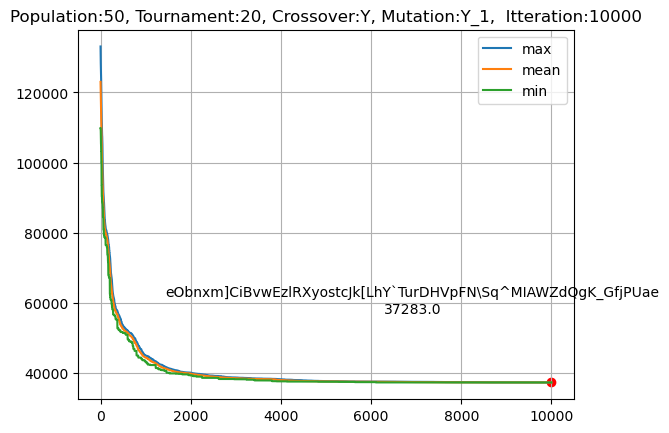

In [94]:
plt.title('Population:{}, Tournament:{}, Crossover:{}, Mutation:{}_{},  Itteration:{}'.format(\
sample_population_size , number_of_contenders_for_tournament, crossover_check , mutation_check , no_of_genes_to_mutate, \
 number_of_itterations ))
plt.plot(itteration , max_cost_list , label = 'max')
plt.plot(itteration , mean_cost_list, label = 'mean')
plt.plot(itteration , min_cost_list, label = 'min')
plt.legend()
plt.scatter(len(itteration) , min(min_cost_list),color = 'red')
plt.grid(True)
# the following will be annotate the text 
annotation_text = '{}\n{}'.format( best_path , min(min_cost_list))
plt.annotate(annotation_text, xy=(len(itteration), min(min_cost_list)), textcoords='offset points', xytext=(-100, 50), ha='center')
# the following will save the figure
plt.savefig('Index{}_P{}_T{}_C{}_M{}{}_\
I{}.jpg'.format(pic_index , sample_population_size , number_of_contenders_for_tournament,\
                crossover_check  , mutation_check , no_of_genes_to_mutate, number_of_itterations))
# this will add the index for the experimentation
pic_index += 1